In [1]:
import pandas as pd
import numpy as np
from pycaret.regression import *
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import linprog
import requests
from datetime import datetime
from pulp import LpMaximize, LpProblem, LpVariable, lpSum

In [2]:
# Base API URL
BASE_URL = "https://fantasy.premierleague.com/api"

# Helper function to calculate extra fields
def is_weekend(day):
    return 1 if day.lower() in ["saturday", "sunday"] else 0

# Fetch data from the main API endpoints
bootstrap_static = requests.get(f"{BASE_URL}/bootstrap-static/").json()
fixtures = requests.get(f"{BASE_URL}/fixtures/").json()

# Extract general data
players = pd.DataFrame(bootstrap_static['elements'])
teams = pd.DataFrame(bootstrap_static['teams'])
positions = pd.DataFrame(bootstrap_static['element_types'])

# Map team and position IDs to readable names
team_map = teams.set_index('id')['name'].to_dict()
position_map = positions.set_index('id')['singular_name_short'].to_dict()

players['team'] = players['team'].map(team_map)
players['position'] = players['element_type'].map(position_map)

# Add a new column for players' full names
players['full_name'] = players['first_name'] + " " + players['second_name']

# Prepare fixtures DataFrame for difficulty ratings
fixtures_df = pd.DataFrame(fixtures)
fixtures_df = fixtures_df[['id', 'team_h_difficulty', 'team_a_difficulty']]

# Prepare Gameweek-specific data
gameweek_data = []

for player_id in players['id']:
    # Fetch player-specific gameweek history
    player_data = requests.get(f"{BASE_URL}/element-summary/{player_id}/").json()
    history = player_data['history']
    
    for match in history:
        kickoff_datetime = datetime.strptime(match['kickoff_time'], '%Y-%m-%dT%H:%M:%SZ')
        kickoff_day = kickoff_datetime.strftime('%A')
        kickoff_hour = kickoff_datetime.hour

        # Fetch difficulty ratings from fixtures data
        fixture_data = fixtures_df[fixtures_df['id'] == match['fixture']]
        team_h_difficulty = fixture_data['team_h_difficulty'].values[0] if not fixture_data.empty else None
        team_a_difficulty = fixture_data['team_a_difficulty'].values[0] if not fixture_data.empty else None

        # Calculate transfers_balance
        transfers_in = players.loc[players['id'] == player_id, 'transfers_in'].values[0]
        transfers_out = players.loc[players['id'] == player_id, 'transfers_out'].values[0]
        transfers_balance = transfers_in - transfers_out

        gameweek_data.append({
            'name': players.loc[players['id'] == player_id, 'full_name'].values[0],  # Use full_name here
            'position': players.loc[players['id'] == player_id, 'position'].values[0],
            'team': players.loc[players['id'] == player_id, 'team'].values[0],
            'xP': match.get('expected_points', 0),
            'assists': match['assists'],
            'bonus': match['bonus'],
            'bps': match['bps'],
            'clean_sheets': match['clean_sheets'],
            'creativity': match['creativity'],
            'element': player_id,
            'expected_assists': match.get('xA', 0),
            'expected_goal_involvements': match.get('xGI', 0),
            'expected_goals': match.get('xG', 0),
            'expected_goals_conceded': match.get('xGC', 0),
            'fixture': match['fixture'],
            'goals_conceded': match['goals_conceded'],
            'goals_scored': match['goals_scored'],
            'ict_index': match['ict_index'],
            'influence': match['influence'],
            'kickoff_time': kickoff_datetime,
            'minutes': match['minutes'],
            'opponent_team': match['opponent_team'],
            'own_goals': match['own_goals'],
            'penalties_missed': match['penalties_missed'],
            'penalties_saved': match['penalties_saved'],
            'red_cards': match['red_cards'],
            'round': match['round'],
            'saves': match['saves'],
            'selected': players.loc[players['id'] == player_id, 'selected_by_percent'].values[0],
            'starts': int(match['minutes'] > 0),
            'team_a_score': match['team_a_score'],
            'team_h_score': match['team_h_score'],
            'threat': match['threat'],
            'total_points': match['total_points'],
            'transfers_balance': transfers_balance,
            'transfers_in': transfers_in,
            'transfers_out': transfers_out,
            'value': players.loc[players['id'] == player_id, 'now_cost'].values[0],
            'was_home': match['was_home'],
            'yellow_cards': match['yellow_cards'],
            'GW': match['round'],
            'team_h_difficulty': team_h_difficulty,
            'team_a_difficulty': team_a_difficulty,
            'kickoff_hour': kickoff_hour,
            'kickoff_day': kickoff_day,
            'is_weekend': is_weekend(kickoff_day),
        })

# Convert to DataFrame
data = pd.DataFrame(gameweek_data)

# Format columns and ensure correct data types
data['kickoff_time'] = pd.to_datetime(data['kickoff_time'], utc=True)
data['team_h_difficulty'] = data['team_h_difficulty'].astype('category')
data['team_a_difficulty'] = data['team_a_difficulty'].astype('category')
data['ict_index'] = pd.to_numeric(data['ict_index'], errors='coerce')
data['influence'] = pd.to_numeric(data['influence'], errors='coerce')
data['selected'] = pd.to_numeric(data['selected'], errors='coerce')

fixtures_file_path = 'https://raw.githubusercontent.com/vaastav/Fantasy-Premier-League/refs/heads/master/data/2024-25/fixtures.csv'
fixtures = pd.read_csv(fixtures_file_path)

In [3]:
# Check for missing values
data = data.dropna()

In [4]:
# Quick overview of the dataset
print("Dataset Overview:")
print(data.info())
print("\nSummary Statistics:")
print(data.describe())

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9927 entries, 0 to 9926
Data columns (total 46 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   name                        9927 non-null   object             
 1   position                    9927 non-null   object             
 2   team                        9927 non-null   object             
 3   xP                          9927 non-null   int64              
 4   assists                     9927 non-null   int64              
 5   bonus                       9927 non-null   int64              
 6   bps                         9927 non-null   int64              
 7   clean_sheets                9927 non-null   int64              
 8   creativity                  9927 non-null   object             
 9   element                     9927 non-null   int64              
 10  expected_assists            9927 non-null 

In [5]:
# Data Preprocessing: Ensure numerical columns are in the correct type and drop unnecessary columns
data['xP'] = pd.to_numeric(data['xP'], errors='coerce')
data['total_points'] = pd.to_numeric(data['total_points'], errors='coerce')
data['transfers_balance'] = pd.to_numeric(data['transfers_balance'], errors='coerce')
data['value'] = pd.to_numeric(data['value'], errors='coerce')
data['threat'] = pd.to_numeric(data['threat'], errors='coerce')
data['creativity'] = pd.to_numeric(data['creativity'], errors='coerce')
data['team_h_difficulty'] = data['team_h_difficulty'].astype('category')
data['team_a_difficulty'] = data['team_a_difficulty'].astype('category')


# Convert kickoff_time to datetime
data['kickoff_time'] = pd.to_datetime(data['kickoff_time'], errors='coerce')

# Extract useful temporal features
data['kickoff_hour'] = data['kickoff_time'].dt.hour
data['kickoff_day'] = data['kickoff_time'].dt.day_name()
data['is_weekend'] = data['kickoff_time'].dt.weekday >= 5  # Saturday and Sunday as weekend
data['is_weekend'] = data['is_weekend'].astype(int)

# Drop rows where target column is missing
data = data.dropna(subset=['total_points'])

# Encoding categorical variables (for machine learning models)
data_model = pd.get_dummies(data, columns=['position', 'team', 'starts', 'team_h_difficulty', 'team_a_difficulty', 'kickoff_day'], drop_first=True)
data_model = data_model.drop(columns=['fixture'])
data_model = data_model.drop(columns=['kickoff_time', 'bps', 'bonus', 'xP'])

data_model.head()

,name,assists,clean_sheets,creativity,element,expected_assists,expected_goal_involvements,expected_goals,expected_goals_conceded,goals_conceded,...,team_h_difficulty_5,team_a_difficulty_3,team_a_difficulty_4,team_a_difficulty_5,kickoff_day_Monday,kickoff_day_Saturday,kickoff_day_Sunday,kickoff_day_Thursday,kickoff_day_Tuesday,kickoff_day_Wednesday
0,Fábio Ferreira Vieira,0,0,0.0,1,0,0,0,0,0,...,False,False,False,True,False,True,False,False,False,False
1,Fábio Ferreira Vieira,0,0,0.0,1,0,0,0,0,0,...,True,False,True,False,False,True,False,False,False,False
2,Fábio Ferreira Vieira,0,0,0.0,1,0,0,0,0,0,...,False,False,False,True,False,True,False,False,False,False
3,Fábio Ferreira Vieira,0,0,0.0,1,0,0,0,0,0,...,True,False,True,False,False,False,True,False,False,False
4,Fábio Ferreira Vieira,0,0,0.0,1,0,0,0,0,0,...,True,False,False,True,False,False,True,False,False,False


In [6]:
data_model.columns = data_model.columns.str.replace(' ', '_').str.replace("'", "").str.strip()

# Set up the PyCaret environment for regression
regression_setup = setup(
    data=data_model,
    target='total_points',
    session_id=123,
    normalize=True,
    normalize_method='robust',
    preprocess=True,
    multicollinearity_threshold=0.85,
    fold_strategy='kfold',
    fold=5
)
# Compare different models
best_model = compare_models()

# Train the best model on the full dataset
final_model = finalize_model(best_model)

# Make predictions for the next gameweek (assuming you have future gameweek data)
predictions = predict_model(final_model, data_model)
predictions

,Description,Value
0,Session id,123
1,Target,total_points
2,Target type,Regression
3,Original data shape,"(9927, 70)"
4,Transformed data shape,"(9927, 70)"
5,Transformed train set shape,"(6948, 70)"
6,Transformed test set shape,"(2979, 70)"
7,Numeric features,32
8,Categorical features,1
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.0935,0.1318,0.3615,0.9757,0.0642,0.0467,0.1900
catboost,CatBoost Regressor,0.1095,0.1366,0.3631,0.9753,0.0550,0.0651,0.9480
xgboost,Extreme Gradient Boosting,0.1192,0.1905,0.4342,0.9651,0.0659,0.0665,0.2480
rf,Random Forest Regressor,0.1084,0.1983,0.4425,0.9637,0.0734,0.0514,0.2940
lightgbm,Light Gradient Boosting Machine,0.1493,0.2554,0.5014,0.9533,0.0967,0.0969,0.0880
gbr,Gradient Boosting Regressor,0.2064,0.2609,0.5098,0.9518,0.1155,0.1599,0.2440
dt,Decision Tree Regressor,0.1193,0.3263,0.5651,0.9406,0.0889,0.0505,0.0340
lr,Linear Regression,0.3303,0.4176,0.6455,0.9222,0.1769,0.2825,0.7440
br,Bayesian Ridge,0.3304,0.4177,0.6456,0.9222,0.1768,0.2830,0.0320
ridge,Ridge Regression,0.3309,0.4193,0.6468,0.9218,0.1770,0.2847,0.0300


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.0000,0.0000,0.0000,1.0000,0.0002,0.0000


,name,assists,clean_sheets,creativity,element,expected_assists,expected_goal_involvements,expected_goals,expected_goals_conceded,goals_conceded,...,team_a_difficulty_4,team_a_difficulty_5,kickoff_day_Monday,kickoff_day_Saturday,kickoff_day_Sunday,kickoff_day_Thursday,kickoff_day_Tuesday,kickoff_day_Wednesday,total_points,prediction_label
0,Fábio Ferreira Vieira,0,0,0.0,1,0,0,0,0,0,...,False,True,False,True,False,False,False,False,0,0.0
1,Fábio Ferreira Vieira,0,0,0.0,1,0,0,0,0,0,...,True,False,False,True,False,False,False,False,0,0.0
2,Fábio Ferreira Vieira,0,0,0.0,1,0,0,0,0,0,...,False,True,False,True,False,False,False,False,0,0.0
3,Fábio Ferreira Vieira,0,0,0.0,1,0,0,0,0,0,...,True,False,False,False,True,False,False,False,0,0.0
4,Fábio Ferreira Vieira,0,0,0.0,1,0,0,0,0,0,...,False,True,False,False,True,False,False,False,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9922,Alfie Pond,0,0,0.0,664,0,0,0,0,0,...,False,False,True,False,False,False,False,False,0,0.0
9923,Tom Edozie,0,0,0.0,682,0,0,0,0,0,...,False,False,False,True,False,False,False,False,0,0.0
9924,Tom Edozie,0,0,0.0,682,0,0,0,0,0,...,False,False,False,True,False,False,False,False,0,0.0
9925,Tom Edozie,0,0,0.0,682,0,0,0,0,0,...,False,False,False,False,False,False,False,True,0,0.0


In [7]:
# Display the feature importance for tree-based models
if hasattr(final_model, 'feature_importances_'):
    print("Feature Importances:")
    feature_importance = pd.DataFrame({
        'Feature': data_model.drop(columns=['total_points']).columns,
        'Importance': final_model.feature_importances_
    })
    feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
    pd.set_option('display.max_rows', None)  # Show all rows
    display(feature_importance)
else:
    print("The selected model does not support feature importance.")

Feature Importances:


,Feature,Importance
10,goals_scored,0.255969
12,influence,0.147356
13,minutes,0.137165
2,clean_sheets,0.119427
11,ict_index,0.085358
56,starts_1,0.079663
1,assists,0.071224
36,position_MID,0.027727
34,position_FWD,0.017789
30,yellow_cards,0.010397


Summary Statistics for Residuals:
count    145491.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: Residuals, dtype: float64
Residual Analysis by Position:
  position  Mean_Residual  MAE  RMSE  Count
0      DEF            0.0  0.0   0.0  47650
1      FWD            0.0  0.0   0.0  16214
2      GKP            0.0  0.0   0.0  15426
3      MID            0.0  0.0   0.0  66201


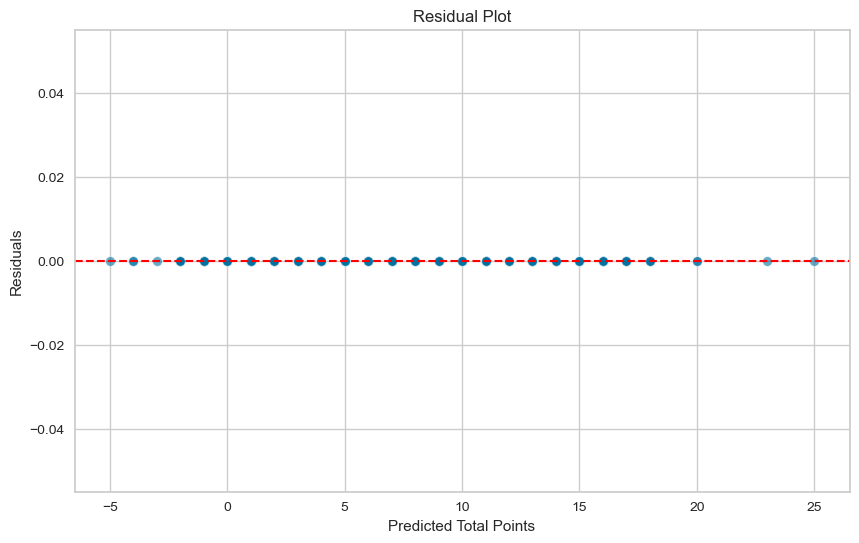

Residual Analysis by Value Bracket:
  Value_Bracket  Mean_Residual  MAE  RMSE   Count
0           Low            0.0  0.0   0.0  104725
1        Medium            0.0  0.0   0.0   39895
2          High            0.0  0.0   0.0     871
3     Very High            NaN  NaN   NaN       0


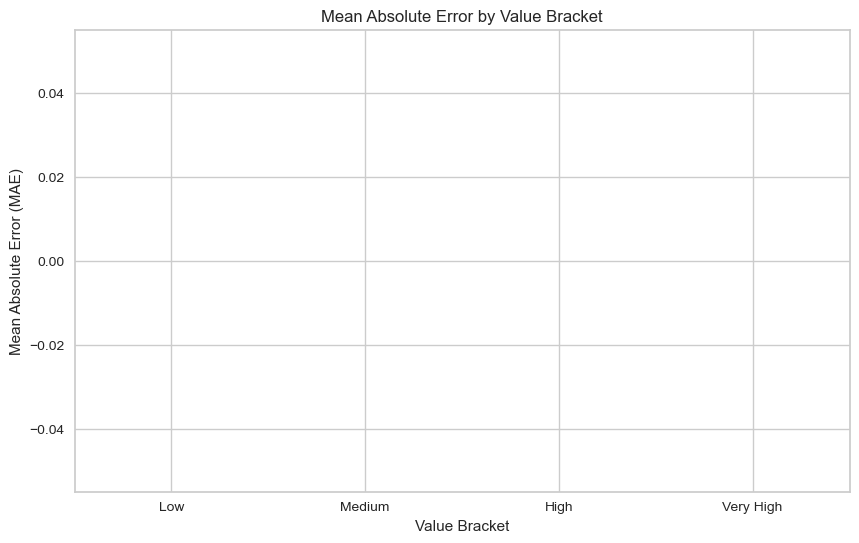

In [8]:
# Step 1: Create a new dataframe to hold residuals
data_with_residuals = data_model.copy()
data_with_residuals['Residuals'] = data_with_residuals['total_points'] - predictions['prediction_label']  # Actual - Predicted
data_with_residuals = data_with_residuals.merge(
    data[['name', 'position']], 
    on='name', 
    how='left'
)

# Step 2: Summary Statistics for Residuals
residual_summary = data_with_residuals['Residuals'].describe()
print("Summary Statistics for Residuals:")
print(residual_summary)

# Step 3: Residuals by Position (if position is available)
if 'position' in data_with_residuals.columns:
    residuals_by_position = data_with_residuals.groupby('position').agg(
        Mean_Residual=('Residuals', 'mean'),
        MAE=('Residuals', lambda x: x.abs().mean()),
        RMSE=('Residuals', lambda x: (x**2).mean()**0.5),
        Count=('Residuals', 'count')
    ).reset_index()
    print("Residual Analysis by Position:")
    print(residuals_by_position)

# Step 4: Residual Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=predictions['prediction_label'], y=data_with_residuals['Residuals'], alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--', linewidth=1.5)
plt.title('Residual Plot')
plt.xlabel('Predicted Total Points')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

# Step 5: Residuals by Value Brackets (if value is available)
if 'value' in data_with_residuals.columns:
    data_with_residuals['Value_Bracket'] = pd.cut(data_with_residuals['value'], bins=[0, 50, 100, 150, 200], labels=['Low', 'Medium', 'High', 'Very High'])
    residuals_by_value_bracket = data_with_residuals.groupby('Value_Bracket').agg(
        Mean_Residual=('Residuals', 'mean'),
        MAE=('Residuals', lambda x: x.abs().mean()),
        RMSE=('Residuals', lambda x: (x**2).mean()**0.5),
        Count=('Residuals', 'count')
    ).reset_index()
    print("Residual Analysis by Value Bracket:")
    print(residuals_by_value_bracket)

    # Visualizing Error Metrics by Value Bracket
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Value_Bracket', y='MAE', data=residuals_by_value_bracket, palette='viridis')
    plt.title('Mean Absolute Error by Value Bracket')
    plt.xlabel('Value Bracket')
    plt.ylabel('Mean Absolute Error (MAE)')
    plt.grid(True)
    plt.show()

In [9]:
# Define numeric columns for which rolling averages will be calculated 
numeric_columns = [
    'goals_scored', 'assists', 'clean_sheets', 'creativity', 
    'expected_assists', 'expected_goal_involvements', 'expected_goals', 
    'expected_goals_conceded', 'goals_conceded', 'ict_index', 
    'influence', 'minutes', 'own_goals', 'penalties_missed', 'penalties_saved', 
    'red_cards', 'saves', 'selected', 'team_a_score', 'team_h_score', 
    'threat', 'total_points', 'transfers_balance', 'transfers_in', 
    'transfers_out', 'value', 'yellow_cards'
]

# Determine the last 5 GWs dynamically
max_gw = data_model['GW'].max()
last_5_gws = [max_gw - 4, max_gw - 3, max_gw - 2, max_gw - 1, max_gw]

# Filter data for the last 5 GWs
last_5_gws_data = data_model[data_model['GW'].isin(last_5_gws)]

# Define a function to calculate weighted average
def weighted_avg(group, weight_decay=0.5):
    weights = [(weight_decay ** i) for i in range(len(group))]
    weights.reverse()  # Reverse so recent weeks have higher weights
    return (group * weights).sum() / sum(weights)

# Apply the weighted rolling average calculation
rolling_avg_weighted = last_5_gws_data.groupby('name')[numeric_columns].apply(
    lambda df: df.apply(weighted_avg, weight_decay=0.8)  # Adjust decay factor as needed
).reset_index()

# Prepare the template for the next GW (dynamically set to max_gw + 1)
next_gw = max_gw + 1

# Ensure gw_template includes all players, using their most recent data
latest_data_per_player = data_model.sort_values(by=['name', 'GW']).groupby('name').last().reset_index()
gw_template = latest_data_per_player.copy()
gw_template['GW'] = next_gw

# Add team_h_difficulty and team_a_difficulty from the fixtures dataframe
next_gw_fixtures = fixtures[fixtures['event'] == next_gw]
team_difficulty = next_gw_fixtures[['team_h', 'team_h_difficulty', 'team_a', 'team_a_difficulty']]

# Create difficulty mappings
team_h_difficulty_map = team_difficulty.set_index('team_h')['team_h_difficulty'].to_dict()
team_a_difficulty_map = team_difficulty.set_index('team_a')['team_a_difficulty'].to_dict()

# Map difficulties to the gw_template
gw_template['team_h_difficulty'] = gw_template['opponent_team'].map(team_h_difficulty_map)
gw_template['team_a_difficulty'] = gw_template['opponent_team'].map(team_a_difficulty_map)

# Fill missing difficulties with a default value (e.g., average difficulty or 0)
default_difficulty = 3  # Replace with the average or a logical default value
gw_template['team_h_difficulty'] = gw_template['team_h_difficulty'].fillna(default_difficulty).astype('category')
gw_template['team_a_difficulty'] = gw_template['team_a_difficulty'].fillna(default_difficulty).astype('category')

# Fill NaN values in rolling_avg_weighted using the last recorded values for each player
filled_rolling_avg_weighted = rolling_avg_weighted.copy()
filled_rolling_avg_weighted = filled_rolling_avg_weighted.set_index('name')

# Ensure missing values are filled from the player's last recorded values in data_model
for column in numeric_columns:
    # Use the player's last non-NaN value from data_model
    filled_rolling_avg_weighted[column] = filled_rolling_avg_weighted[column].fillna(
        last_5_gws_data.sort_values(by=['name', 'GW']).groupby('name')[column].last()
    )

filled_rolling_avg_weighted.reset_index(inplace=True)

# Merge the updated rolling averages back into the template
fpl_input = gw_template.drop(columns=numeric_columns).merge(
    filled_rolling_avg_weighted, on='name', how='left'
)

In [10]:
Predictions_new_week = predict_model(final_model, fpl_input)
Predictions_new_week.head()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,0.2096,0.1194,0.3455,0.9591,0.1585,0.4033


,name,element,opponent_team,round,was_home,GW,kickoff_hour,is_weekend,position_FWD,position_GKP,...,team_a_score,team_h_score,threat,transfers_balance,transfers_in,transfers_out,value,yellow_cards,total_points,prediction_label
0,Aaron Cresswell,517,20,15,True,16,20,0,False,False,...,1.792004,1.689672,0.000000,-93367.0,81351.0,174718.0,40.0,0.000000,0.297477,0.99
1,Aaron Hickey,93,15,15,True,16,15,1,False,False,...,1.267016,3.030938,0.000000,-2224.0,419.0,2643.0,43.0,0.000000,0.000000,0.00
2,Aaron Ramsdale,14,2,15,False,16,15,1,False,True,...,1.837220,1.274155,0.000000,30476.0,257304.0,226828.0,44.0,0.121847,0.000000,-0.06
3,Aaron Wan-Bissaka,388,20,15,True,16,20,0,False,False,...,1.792004,1.689672,8.752975,407684.0,591941.0,184257.0,46.0,0.000000,4.990957,4.98
4,Abdoulaye Doucouré,217,20,14,True,16,19,0,False,False,...,0.000000,2.439024,2.875339,-33015.0,17065.0,50080.0,51.0,0.000000,2.728997,2.70


In [11]:
# Step 1: Recreate unique_data from data_model
unique_data = data[['name', 'position', 'team']].drop_duplicates(subset='name')  # Include 'team'

# Step 2: Get the last known value for each player
last_known_values = data.groupby('name').last().reset_index()[['name', 'value']]

# Step 3: Merge the position and team columns into Predictions_new_week and add value from the last known record
merged_predictions = Predictions_new_week.merge(
    unique_data[['name', 'position', 'team']],  # Include 'team' in the merge
    on='name',
    how='left'
).merge(
    last_known_values.rename(columns={'value': 'last_known_value'}),  # Rename to avoid column conflict
    on='name',
    how='left'
)

# Step 4: Fill NaN values in 'value' column with the last known value for players who don't have a record in the last GW
merged_predictions['value'] = merged_predictions['last_known_value']

# Step 5: Drop the helper column 'last_known_value'
merged_predictions.drop(columns=['last_known_value'], inplace=True)

# Step 6: Calculate Points per Million (PPM)
merged_predictions['PPM'] = merged_predictions['prediction_label'] / merged_predictions['value']

# Step 7: Sort by PPM for better insights (optional)
merged_predictions = merged_predictions.sort_values(by='PPM', ascending=False)

# Step 8: Keep only the required columns
merged_predictions = merged_predictions[['name', 'prediction_label', 'position', 'team', 'value', 'PPM']]
merged_predictions

,name,prediction_label,position,team,value,PPM
188,Enzo Fernández,8.23,MID,Chelsea,50,0.164600
381,Kevin Schade,7.87,MID,Brentford,51,0.154314
54,Ashley Young,6.94,DEF,Everton,46,0.150870
660,Vitalii Mykolenko,6.07,DEF,Everton,43,0.141163
145,Daniel Muñoz,5.84,DEF,Crystal Palace,47,0.124255
15,Alex Iwobi,7.04,MID,Fulham,57,0.123509
675,William Saliba,7.31,DEF,Arsenal,62,0.117903
297,James Tarkowski,5.55,DEF,Everton,48,0.115625
363,Justin Kluivert,6.33,MID,Bournemouth,55,0.115091
338,Jordan Pickford,5.61,GKP,Everton,49,0.114490


In [12]:
# Calculate Points per Million (PPM)
merged_predictions['PPM'] = merged_predictions['prediction_label'] / ( merged_predictions['value'] / 10 )

# Analyze top players to buy

# Number of top players to recommend per position
top_n = 10

# Group by position and select top N players by `prediction_label`
top_players = merged_predictions.groupby('position').apply(
    lambda group: group.nlargest(top_n, 'prediction_label')
).reset_index(drop=True)

# Sort the recommendations by position and PPM for better insights
top_players = top_players.sort_values(by=['position', 'PPM'], ascending=[True, False])

# Save the recommendations to a CSV for review
top_players.to_csv('top_player_recommendations_with_ppm.csv', index=False)

# Print the recommendations
top_players

,name,prediction_label,position,team,value,PPM
1,Ashley Young,6.94,DEF,Everton,46,1.508696
2,Vitalii Mykolenko,6.07,DEF,Everton,43,1.411628
3,Daniel Muñoz,5.84,DEF,Crystal Palace,47,1.242553
0,William Saliba,7.31,DEF,Arsenal,62,1.179032
4,James Tarkowski,5.55,DEF,Everton,48,1.156250
6,Aaron Wan-Bissaka,4.98,DEF,West Ham,46,1.082609
7,Jarrad Branthwaite,4.98,DEF,Everton,48,1.037500
8,Maxence Lacroix,4.40,DEF,Crystal Palace,45,0.977778
9,Milos Kerkez,4.18,DEF,Bournemouth,46,0.908696
5,Jurriën Timber,5.01,DEF,Arsenal,56,0.894643


In [13]:
# Load your dataframe (replace this with your actual dataframe if already loaded)
best_team = top_players  # Assuming this is the dataframe in your notebook

# Set up constraints for positions
constraints = {
    "GKP": 2,  # Max 2 Goalkeepers
    "DEF": 5,  # Max 5 Defenders
    "MID": 5,  # Max 5 Midfielders
    "FWD": 3,  # Max 3 Forwards
}
budget = 100  # Example budget in million units

# Prepare data for optimization
best_team['selected'] = 0  # Binary variable: 1 if player is selected, 0 otherwise
best_team['cost'] = best_team['value'] / 10  # Assuming 'value' is the cost
best_team['prediction_label'] = best_team['prediction_label']

# Objective function (maximize PPM)
c = -best_team['prediction_label'].values  # Negate for maximization as linprog minimizes

# Budget constraint
A = [best_team['cost'].values]
b = [budget]

# Position constraints
for pos, max_players in constraints.items():
    A.append((best_team['position'] == pos).astype(int).values)
    b.append(max_players)

# Bounds for each player (0 or 1)
bounds = [(0, 1) for _ in range(len(best_team))]

# Solve using linear programming
result = linprog(c, A_ub=A, b_ub=b, bounds=bounds, method='highs')

# Add the selected players back to the dataframe
best_team['selected'] = result.x.round().astype(int)

# Filter selected players
best_team_final = best_team[best_team['selected'] == 1]


# Save the best team to a CSV for review
best_team_final.to_csv('best_team.csv', index=False)

best_team_final

,name,prediction_label,position,team,value,PPM,selected,cost
1,Ashley Young,6.94,DEF,Everton,46,1.508696,1,4.6
2,Vitalii Mykolenko,6.07,DEF,Everton,43,1.411628,1,4.3
3,Daniel Muñoz,5.84,DEF,Crystal Palace,47,1.242553,1,4.7
0,William Saliba,7.31,DEF,Arsenal,62,1.179032,1,6.2
4,James Tarkowski,5.55,DEF,Everton,48,1.156250,1,4.8
11,Jamie Vardy,6.12,FWD,Leicester,55,1.112727,1,5.5
12,Yoane Wissa,5.68,FWD,Brentford,62,0.916129,1,6.2
10,Alexander Isak,6.56,FWD,Newcastle,86,0.762791,1,8.6
20,Jordan Pickford,5.61,GKP,Everton,49,1.144898,1,4.9
21,Caoimhin Kelleher,4.86,GKP,Liverpool,46,1.056522,1,4.6


In [14]:
best_team_final['prediction_label'].sum()

109.51

In [15]:
best_team_final['cost'].sum()

94.6